In [1]:
# default_exp gan.learner

# gan.learner

> API details.

In [2]:
# export

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.nn import BCELoss, CrossEntropyLoss
from fastrenewables.tabular.data import *
from fastrenewables.tabular.core import *
from fastrenewables.gan.model import *
from fastrenewables.timeseries.model import TemporalCNN
import glob

In [3]:
# export

class DummyDataset(torch.utils.data.Dataset):

    def __init__(self, n_samples=10000, n_cat_feats=4, n_cont_feats=16, n_targets=1):

        self.n_samples = n_samples
        self.cat = torch.rand(n_cat_feats, n_samples)
        self.cont = torch.rand(n_cont_feats, n_samples)
        self.y = torch.rand(n_targets, n_samples)

    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        x_cat = self.cat[:, idx]
        x_cont = self.cont[:, idx]
        y = self.y[:, idx]
        return x_cat, x_cont, y
    
class DummyDatasetTS(torch.utils.data.Dataset):

    def __init__(self, n_samples=10000, n_cat_feats=4, n_cont_feats=16, n_targets=1, len_ts=96):

        self.n_samples = n_samples
        self.cat = torch.rand(n_samples, n_cat_feats, len_ts)
        self.cont = torch.rand(n_samples, n_cont_feats, len_ts)
        self.y = torch.rand(n_samples, n_targets)

    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        x_cat = self.cat[idx]
        x_cont = self.cont[idx]
        y = self.y[idx]
        return x_cat, x_cont, y
    

class Gan(nn.Module):
    
    def __init__(self, generator, discriminator, gen_optim, dis_optim, auxiliary=False, auxiliary_weighting_factor=1):
        super(Gan, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.gen_optim = gen_optim
        self.dis_optim = dis_optim
        self.real_loss = []
        self.fake_loss = []
        self.auxiliary = auxiliary
        self.bce_loss = BCELoss()
        self.auxiliary_loss_function = CrossEntropyLoss()
        self.auxiliary_weighting_factor=auxiliary_weighting_factor
        
    def to_device(self, device):
        self.generator = self.generator.to(device)
        self.discriminator = self.discriminator.to(device)
        self.bce_loss = self.bce_loss.to(device)
        self.auxiliary_loss_function = self.auxiliary_loss_function.to(device)
        
    def _split_pred(self, y):
        if self.auxiliary:
            y, class_probs = y
        else:
            y, class_probs = y, None
        return y, class_probs
    
    def auxiliary_loss(self, class_probs, y):
        return self.auxiliary_loss_function(class_probs, y.ravel().to(torch.int64))*self.auxiliary_weighting_factor
    
    def train_generator(self, z, x_cat, x_cont, y):
        # train the generator model
        self.generator.zero_grad()
        x_cont_fake = self.generator(x_cat, z)
        y_fake = self.discriminator(None, x_cont_fake)  
        y_fake, class_probs = self._split_pred(y_fake)
        loss = self.bce_loss(y_fake, torch.ones_like(y_fake))
        if self.auxiliary:
            aux_loss = self.auxiliary_loss(class_probs, y)
            loss = (loss + aux_loss)/2
        loss.backward()
        self.gen_optim.step()
        return
    
    def train_discriminator(self, z, x_cat, x_cont, y):
        # train the discriminator model
        self.discriminator.zero_grad()
        y_real = self.discriminator(None, x_cont)
        y_real, class_probs = self._split_pred(y_real)
        real_loss = self.bce_loss(y_real, torch.ones_like(y_real))
        if self.auxiliary:
            aux_loss = self.auxiliary_loss(class_probs, y)
            real_loss = (real_loss + aux_loss)/2
        
        real_loss.backward()
        self.dis_optim.step()
        self.real_loss.append(real_loss.item())
        
        self.discriminator.zero_grad()
        x_cont_fake = self.generator(x_cat, z).detach()
        y_fake = self.discriminator(None, x_cont_fake)
        y_fake, class_probs = self._split_pred(y_fake)
        
        fake_loss =  self.bce_loss(y_fake, torch.zeros_like(y_fake))
        if self.auxiliary:
            aux_loss = self.auxiliary_loss(class_probs, y)
            fake_loss = (fake_loss + aux_loss)/2
            
        fake_loss.backward()
        self.dis_optim.step()
        self.fake_loss.append(fake_loss.item())
        return
    

class W_Gan(nn.Module):
    def __init__(self, generator, discriminator, gen_optim, dis_optim, clip=0.001):
        super(W_Gan, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.gen_optim = gen_optim
        self.dis_optim = dis_optim
        self.clip = clip
        self.real_loss = []
        self.fake_loss = []
        
    def train_generator(self, z, x_cat, x_cont, y):
        # train the generator model
        self.generator.zero_grad()
        x_cont_fake = self.generator(x_cat, z)
        y_fake = self.discriminator(None, x_cont_fake)
        loss = - y_fake.mean()
        loss.backward()
        self.gen_optim.step()
        return
    
    def train_discriminator(self, z, x_cat, x_cont, y):
        # train the discriminator model
        self.discriminator.zero_grad()
        y_real = self.discriminator(None, x_cont)
        real_loss = - y_real.mean()
        real_loss.backward()
        self.dis_optim.step()
        self.real_loss.append(real_loss.item())
        
        self.discriminator.zero_grad()
        x_cont_fake = self.generator(x_cat, z).detach()
        y_fake = self.discriminator(None, x_cont_fake)
        fake_loss = y_fake.mean()
        fake_loss.backward()
        self.dis_optim.step()
        self.fake_loss.append(fake_loss.item())
        
        for p in self.discriminator.parameters():
            p = torch.clamp(p, -self.clip, self.clip)
        return

    
class GanLearner():
    def __init__(self, gan, n_z=100):
        super(GanLearner, self).__init__()
        # gan should contain a class which itself contains a generator and discriminator/critic class and combines them
        self.gan = gan
        self.n_z = n_z
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        #self.device = torch.device('cpu')
        
    def noise(self, x):
        if x.dim() == 2:
            z = torch.randn(x.shape[0], self.n_z).to(self.device)
        elif x.dim() == 3:
            z = torch.randn(x.shape[0], self.n_z, x.shape[2]).to(self.device)
        return z
    
    def generate_samples(self, x):
        z = self.noise(x)
        fake_samples = self.gan.generator(z, z).detach()
        return fake_samples
    
    def fit(self, dl, epochs=10, n_gen=1, n_dis=1, plot_epochs=10):
        # train gan and store parameters and losses in given class
        self.gan.to_device(self.device)
        
        for e in tqdm(range(epochs)):
            
            for x_cat, x_cont, y in dl:
                x_cat = x_cat.to(self.device)
                x_cont = x_cont.to(self.device)
                y = y.to(self.device)
                if y.dim() == 3:
                    y = y.flatten(1, 2)[:, 0]
                
                for _ in range(n_dis):
                    z = self.noise(x_cont)
                    self.gan.train_discriminator(z, x_cat, x_cont, y)

                for _ in range(n_gen):
                    z = self.noise(x_cont)
                    self.gan.train_generator(z, x_cat, x_cont, y)
                break
                
            if (e+1)%plot_epochs==0:
                plt.figure(figsize=(16, 9))
                plt.plot(self.gan.real_loss, label='Real Loss')
                plt.plot(self.gan.fake_loss, label='Fake Loss')
                plt.legend()
                plt.show()
                
        self.gan.to_device('cpu')
        
        return

# Tests:

In [8]:
config = {"model_type" : "cnn", # 'mlp' or 'cnn'
          "n_noise_samples": 100,
          "act_func_gen": nn.ReLU(),
          "act_func_dis": nn.LeakyReLU(0.2),
          "final_activation_gen": nn.Sigmoid,
          "final_activation_dis": nn.Sigmoid,
          "lr": 1 * 1e-4,
          "epochs": 1000,
          #"is_bce_model": True, # also adjustable for wgan/wasserstein-loss
          "auxiliary": False
}

In [9]:
#? TemporalCNN

torch.Size([32, 4, 96]) torch.Size([32, 16, 96]) torch.Size([32, 1])


100%|█████████▉| 996/1000 [00:26<00:00, 37.26it/s]

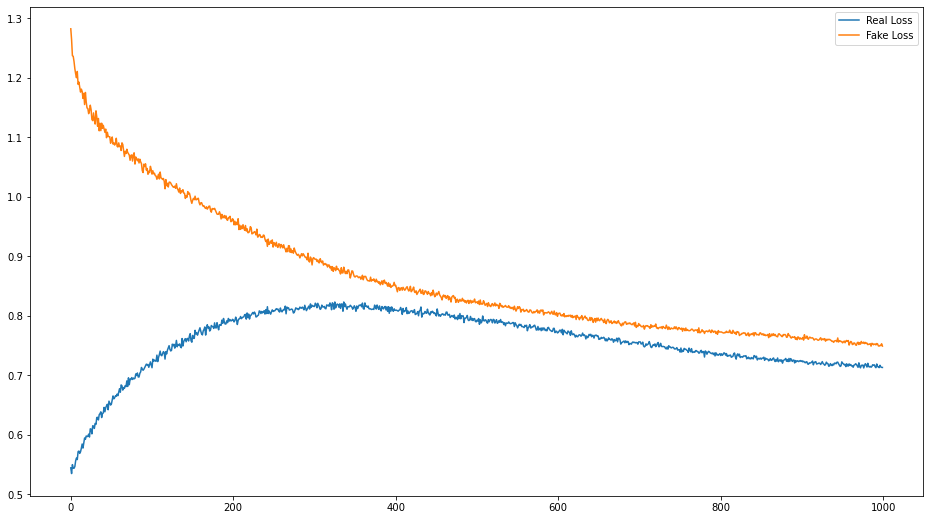

100%|██████████| 1000/1000 [00:26<00:00, 37.10it/s]


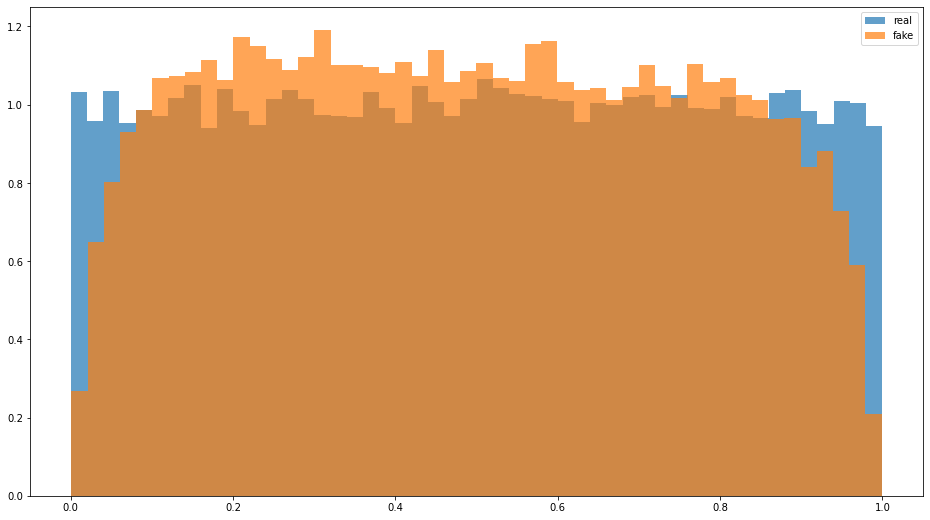

In [10]:
if config['model_type'] == 'mlp':
    data = DummyDataset()
    model_fct = GANMLP
elif config['model_type'] == 'cnn':
    data = DummyDatasetTS()
    model_fct = TemporalCNN
dl = torch.utils.data.DataLoader(data, batch_size=32, shuffle=True, drop_last=True)
for x_cat, x_cont, y in dl:
    print(x_cat.shape, x_cont.shape, y.shape)
    break

n_cont_feats = x_cont.shape[1]
gen_structure = [config['n_noise_samples'], 64, n_cont_feats]
dis_structure = [n_cont_feats, 64, 1]

generator = model_fct(gen_structure, final_activation=config['final_activation_gen'], cnn_type='cnn' ,transpose=True)
if config['auxiliary']:
    n_classes = x_cont.shape[1]
    input_size = dis_structure[-2]
    discriminator = model_fct(dis_structure[:-1], final_activation=config['final_activation_dis'], cnn_type='cnn')
    discriminator = AuxiliaryDiscriminator(discriminator, n_classes, input_size, model_type=config['model_type'])
else:
    discriminator = model_fct(dis_structure, final_activation=config['final_activation_dis'], cnn_type='cnn')

gen_optim = torch.optim.RMSprop(generator.parameters(), lr=config['lr'])
dis_optim = torch.optim.RMSprop(discriminator.parameters(), lr=config['lr'])
gan = Gan(generator, discriminator, gen_optim, dis_optim, auxiliary=config['auxiliary'])
learn = GanLearner(gan)

learn.device = torch.device('cpu')
learn.fit(dl, epochs=config['epochs'], plot_epochs=config['epochs'])

learn.device = torch.device('cpu')

x_real = x_cont.reshape(1, -1)
x_fake = learn.generate_samples(x_cont).reshape(1, -1)

plt.figure(figsize=(16, 9))
plt.hist(x_real, bins=50, label='real', alpha=0.7, density=True)
plt.hist(x_fake, bins=50, label='fake', alpha=0.7, density=True)
plt.legend()
plt.show()

In [11]:
learn.gan

Gan(
  (generator): TemporalCNN(
    (bn_cont): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layers): TemporalConvNet(
      (temporal_blocks): Sequential(
        (0): BasicTemporalBlock(
          (conv): ConvLayer(
            (0): ConvTranspose1d(100, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
            (1): ReLU()
          )
        )
        (1): BasicTemporalBlock(
          (conv): ConvLayer(
            (0): ConvTranspose1d(64, 16, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
            (1): Sigmoid()
          )
        )
      )
    )
  )
  (discriminator): TemporalCNN(
    (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layers): TemporalConvNet(
      (temporal_blocks): Sequential(
        (0): BasicTemporalBlock(
          (conv): ConvLayer(
            (0): Conv1d(16, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
            (1): ReLU()